In [2]:
!pip3 install catboost


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [127]:
import math
import torch
import metrics
import ruptures
import ordpy as op
import numpy as np
import pandas as pd
from klcpd import KL_CPD
import scipy.stats as st
import colorednoise as cn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from collections import OrderedDict
from LSTM.models import binary_model
from catboost import CatBoostClassifier
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from ruptures.metrics import randindex, precision_recall
from data_generation import Binary_Telegraph_Process as BTP
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import balanced_accuracy_score, f1_score, auc, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [355]:
class synth_cpd_pipeline(object):
    def __init__(self, method='log-return', sample_len=1000, n_epochs=100):
        alpha1 = 1
        alpha2 = 2
        alpha3 = 3
        self.data   = {fr'Белый, $\alpha = {alpha1}$':[], fr'Белый, $\alpha = {alpha2}$':[], fr'Белый, $\alpha = {alpha3}$':[],
                       fr'Розовый, $\alpha = {alpha1}$':[], fr'Розовый, $\alpha = {alpha2}$':[], fr'Розовый, $\alpha = {alpha3}$':[],
                       fr'Красный, $\alpha = {alpha1}$':[], fr'Красный, $\alpha = {alpha2}$':[], fr'Красный, $\alpha = {alpha3}$':[],
                       fr'Синий, $\alpha = {alpha1}$':[], fr'Синий, $\alpha = {alpha2}$':[], fr'Синий, $\alpha = {alpha3}$':[], 
                       fr'Фиолетовый, $\alpha = {alpha1}$':[], fr'Фиолетовый, $\alpha = {alpha2}$':[], fr'Фиолетовый, $\alpha = {alpha3}$':[]}
        self.labels = []
        self.lr     = []
        self.noise  = [fr'Белый, $\alpha = {alpha1}$', fr'Розовый, $\alpha = {alpha1}$', fr'Красный, $\alpha = {alpha1}$', fr'Синий, $\alpha = {alpha1}$', fr'Фиолетовый, $\alpha = {alpha1}$',
                       fr'Белый, $\alpha = {alpha2}$', fr'Розовый, $\alpha = {alpha2}$', fr'Красный, $\alpha = {alpha2}$', fr'Синий, $\alpha = {alpha2}$', fr'Фиолетовый, $\alpha = {alpha2}$',
                       fr'Белый, $\alpha = {alpha3}$', fr'Розовый, $\alpha = {alpha3}$', fr'Красный, $\alpha = {alpha3}$', fr'Синий, $\alpha = {alpha3}$', fr'Фиолетовый, $\alpha = {alpha3}$']
        self.method = method
        self.sample_len = sample_len
        self.random_seeds = [1, 3, 5, 7, 11, 15, 17, 19, 23, 73]
        self.horizon = [1, 2, 5, 10, 25]#, 10, 100]
        self.n_epochs = n_epochs
    
    
    def init_data(self):
        alpha1 = 1
        alpha2 = 2
        alpha3 = 3
        for seed in self.random_seeds:
            # Normal
            self.data[fr'Белый, $\alpha = {alpha1}$'].append(BTP(self.sample_len, np.random.normal, 0, RANDOM_SEED=seed, alpha=alpha1))
            self.data[fr'Белый, $\alpha = {alpha2}$'].append(BTP(self.sample_len, np.random.normal, 0, RANDOM_SEED=seed, alpha=alpha2))
            self.data[fr'Белый, $\alpha = {alpha3}$'].append(BTP(self.sample_len, np.random.normal, 0, RANDOM_SEED=seed, alpha=alpha3))
            # Pink
            self.data[fr'Розовый, $\alpha = {alpha1}$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, 1, RANDOM_SEED=seed, alpha=alpha1))
            self.data[fr'Розовый, $\alpha = {alpha2}$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, 1, RANDOM_SEED=seed, alpha=alpha2))
            self.data[fr'Розовый, $\alpha = {alpha3}$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, 1, RANDOM_SEED=seed, alpha=alpha3))
            # Red
            self.data[fr'Красный, $\alpha = {alpha1}$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, 2, RANDOM_SEED=seed, alpha=alpha1))
            self.data[fr'Красный, $\alpha = {alpha2}$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, 2, RANDOM_SEED=seed, alpha=alpha2))
            self.data[fr'Красный, $\alpha = {alpha3}$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, 2, RANDOM_SEED=seed, alpha=alpha3))
            # Blue
            self.data[fr'Синий, $\alpha = {alpha1}$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, -1, RANDOM_SEED=seed, alpha=alpha1))
            self.data[fr'Синий, $\alpha = {alpha2}$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, -1, RANDOM_SEED=seed, alpha=alpha2))
            self.data[fr'Синий, $\alpha = {alpha3}$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, -1, RANDOM_SEED=seed, alpha=alpha3))
            # Violet
            self.data[fr'Фиолетовый, $\alpha = {alpha1}$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, -2, RANDOM_SEED=seed, alpha=alpha1))
            self.data[fr'Фиолетовый, $\alpha = {alpha2}$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, -2, RANDOM_SEED=seed, alpha=alpha2))
            self.data[fr'Фиолетовый, $\alpha = {alpha3}$'].append(BTP(self.sample_len, cn.powerlaw_psd_gaussian, -2, RANDOM_SEED=seed, alpha=alpha3))

    
    def autoregression_matrix(self, X, periods=1, fill_value=0):
        shifted_x = [pd.DataFrame(X).shift(periods=i, fill_value=fill_value).values for i in range(periods)]
        return np.hstack(tuple(shifted_x))
    
    
    def single_cpd_predict(self, noise):

        qms = []
        f1, acc, pr = dict.fromkeys(self.horizon), dict.fromkeys(self.horizon), dict.fromkeys(self.horizon)

        for btp in tqdm(self.data[noise], desc=noise):
            
            X = np.array(btp.get_data())
            L = btp.labels()#['levels'].values
            y = np.array(btp.labels_)
            # y[y > 0] = 1
    
            if self.method == 'lstm':
                lstm = binary_model(X.astype(np.float32), 0.7, 10, model='lstm', n_epochs=self.n_epochs)
                lstm.model_fit(verbose=0)

            single_qms = []
            
            for h in self.horizon:
    
                if self.method == 'boost':
    
                    X_auto = self.autoregression_matrix(X, periods=h)
                    
                    X_train, X_test, y_train, y_test = tts(X_auto, y, test_size=0.5, shuffle=True, stratify=y)
                    clf = CatBoostClassifier(verbose=0)
                    clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)
                    y_true = y_test
    
                elif self.method == 'lstm':
    
                    y_pred = lstm.labels(lstm.model_predict(h))['MARKS'].tolist()
                    y_true = y
                
                if len(y_true) > len(y_pred):
                    y_true = y_true[abs(len(y_true)-len(y_pred)):]
                else:
                    y_pred = y_pred[abs(len(y_true)-len(y_pred)):]
                
                f1_ = f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
                acc_ = balanced_accuracy_score(y_true, y_pred)
                precision, recall, thr = precision_recall_curve(y_true, y_pred)
                pr_ = auc(recall, precision)

                single_qms.append([f1_, acc_, pr_])
        
            qms.append(single_qms)
        
        mu = np.mean(qms, axis=0)
        er = np.std(qms, axis=0) / np.sqrt(len(qms))

        print(mu)
        
        for h_i, h in enumerate(self.horizon):
            f1[h] = "%.3f ± %.3f" % (mu[h_i][0], er[h_i][0])
            acc[h] = "%.3f ± %.3f" % (mu[h_i][1], er[h_i][1])
            pr[h] = "%.3f ± %.3f" % (mu[h_i][2], er[h_i][2])
            
        return f1, acc, pr
    
    
    def cpd_predict(self):
        f1, acc, pr = dict.fromkeys(self.noise), dict.fromkeys(self.noise), dict.fromkeys(self.noise)

        if len(self.lr) == 0:
            self.init_data()
        
        for noise in tqdm(self.data.keys(), leave=True, position=0):
            if (self.method == 'boost') and (noise == 'Blue 1' or noise == 'Violet 1'):
                continue
            f1[noise], acc[noise], pr[noise] = self.single_cpd_predict(noise)
        
        return pd.DataFrame(f1).T, pd.DataFrame(acc).T, pd.DataFrame(pr).T

    
    def plot_delta_t(self, n_bins=20):

        self.init_data()

        fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(20, 10))

        c = 0
        
        for i, noise in enumerate(self.noise):
    
            labels = np.array([])
            for btp in self.data[noise]:
                X = np.array(btp.get_data())
                L = btp.labels()
                y = np.array(btp.labels_)
                label = np.arange(len(y))[y > 0]
                labels = np.concatenate((labels, np.abs(label[1:]-label[:-1])))
    
            labels = np.array(labels).squeeze()

            # print(noise, )
            c += len(labels)/10_000

            ax[i//5, i%5].set_yscale('log')
            ax[i//5, i%5].hist(labels, n_bins)
            if i%5 == 0:
                ax[i//5, i%5].set_ylabel('Частота', fontsize=16, weight='bold')
            if i//5 == 2:
                ax[i//5, i%5].set_xlabel(r'$\Delta$ t', fontsize=16, weight='bold')
            ax[i//5, i%5].set_title(noise, fontsize=16)
            ax[i//5, i%5].tick_params(labelsize=16)

        # print(c / 15)
        
        fig.suptitle('Частоты расстоянии между точками разладки', fontsize=20, weight='bold')
        plt.tight_layout()
        plt.show()
            
        fig.savefig('histogram_changes.jpeg', format='jpeg', dpi=200)

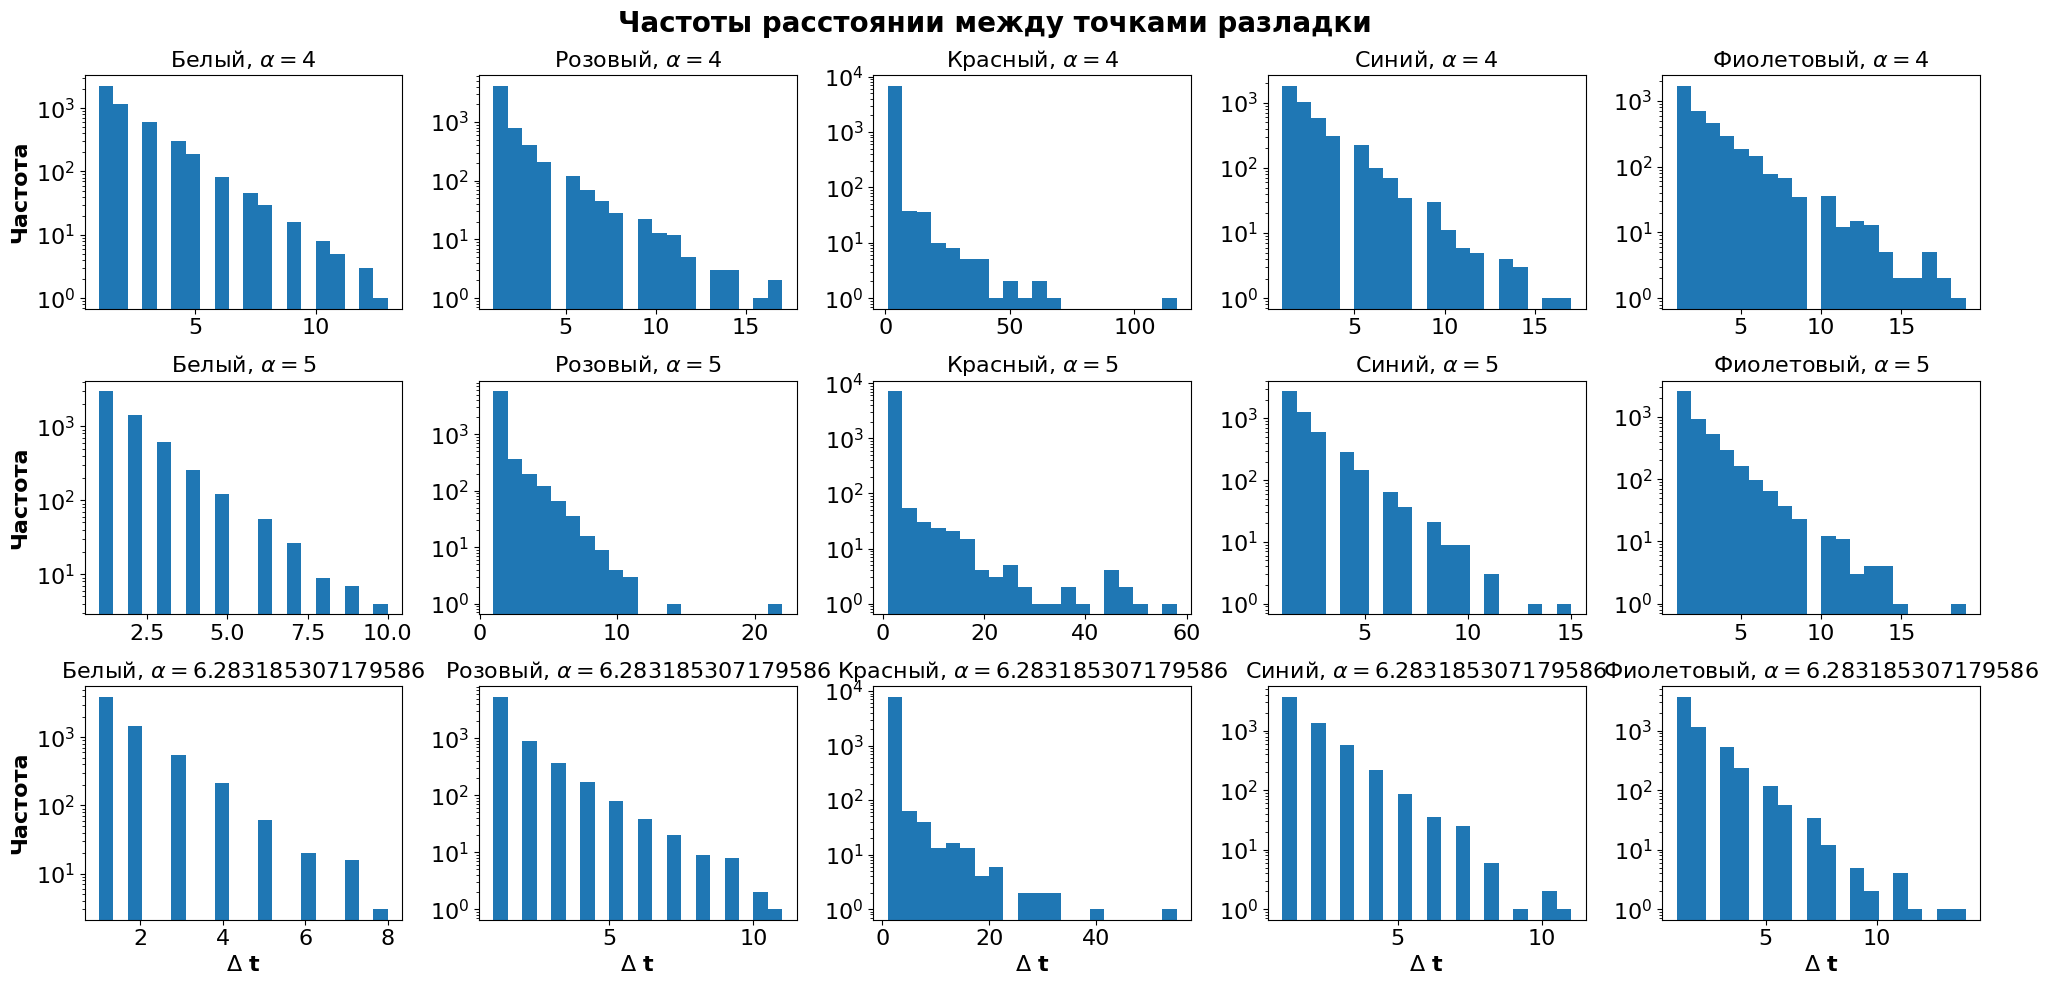

In [349]:
cpd = synth_cpd_pipeline(method='lstm')
cpd.plot_delta_t()

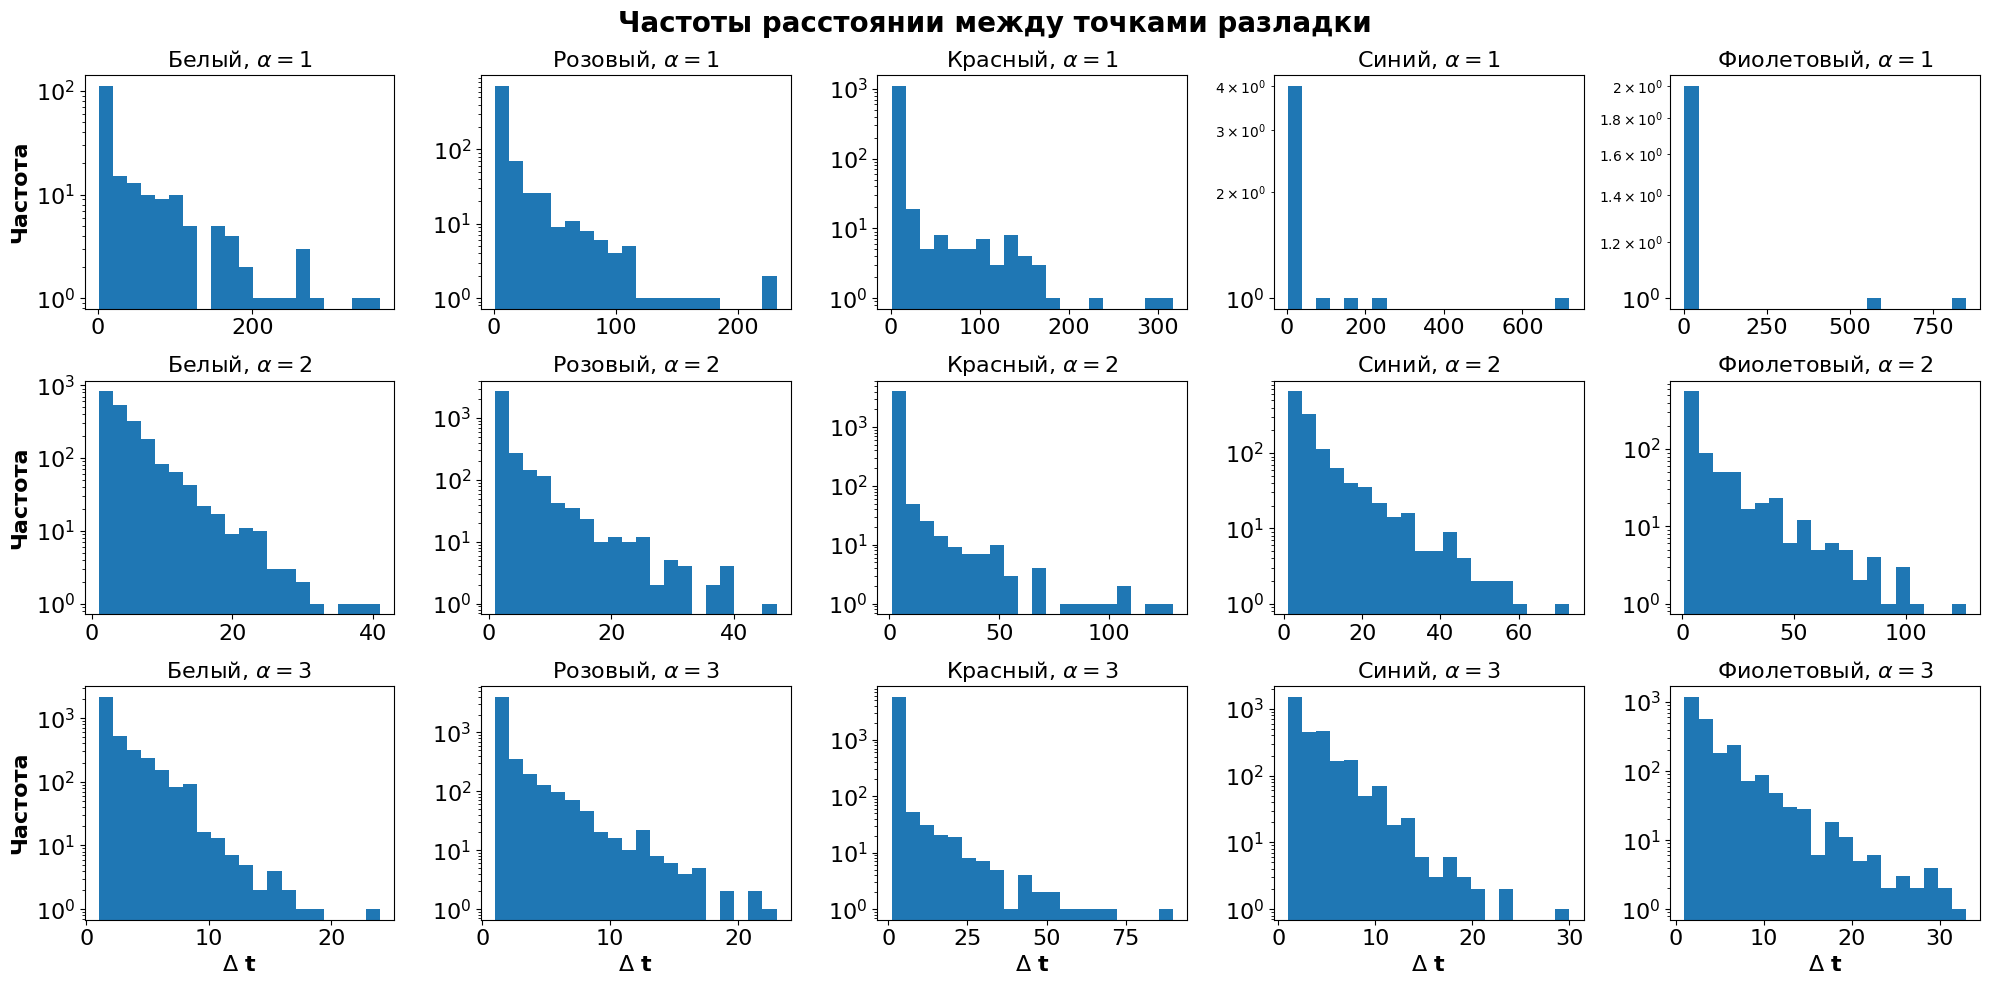

In [356]:
cpd = synth_cpd_pipeline(method='boost')
cpd.plot_delta_t()

In [131]:
f1, acc, pr = cpd.cpd_predict()

  0%|          | 0/15 [00:00<?, ?it/s]

Белый, $\alpha = 4$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.50994439 0.51092833 0.58230144]
 [0.67096667 0.66939221 0.73082109]
 [0.64147787 0.64080575 0.70378909]
 [0.56235113 0.56447615 0.62766053]
 [0.52110064 0.52201173 0.59139314]]


Белый, $\alpha = 5$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.5002405  0.50112746 0.70485308]
 [0.67780563 0.67301239 0.79140731]
 [0.6152061  0.61143155 0.75992185]
 [0.54978887 0.54613622 0.72625439]
 [0.51453009 0.51174586 0.70441809]]


Белый, $\alpha = 6.283185307179586$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.51610847 0.50057847 0.80001512]
 [0.63357469 0.5966892  0.82279077]
 [0.58048686 0.54899009 0.81082625]
 [0.53873678 0.51397513 0.80061306]
 [0.51497762 0.49004954 0.78880162]]


Розовый, $\alpha = 4$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.57412603 0.55797724 0.76890522]
 [0.58416781 0.56751115 0.7729321 ]
 [0.60543743 0.58864193 0.78106576]
 [0.60226494 0.58509397 0.77979855]
 [0.61102683 0.59261343 0.78070629]]


Розовый, $\alpha = 5$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.58220773 0.53349023 0.81279858]
 [0.57969204 0.53202783 0.8108112 ]
 [0.59817862 0.5480102  0.81790199]
 [0.60489272 0.55321469 0.81678123]
 [0.6161209  0.56383985 0.81694171]]


Розовый, $\alpha = 6.283185307179586$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.60595452 0.5164776  0.84575878]
 [0.61521196 0.5240985  0.84583705]
 [0.61760975 0.52586752 0.84574845]
 [0.62969029 0.53647426 0.84760866]
 [0.63504946 0.54194837 0.84630142]]


Красный, $\alpha = 4$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.81966146 0.78052975 0.90771219]
 [0.82490738 0.7920054  0.91133488]
 [0.82969257 0.79433755 0.91295859]
 [0.84134785 0.8056595  0.9177332 ]
 [0.83846233 0.80254178 0.91664239]]


Красный, $\alpha = 5$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.8137154  0.74683307 0.91270019]
 [0.82273392 0.76025747 0.91622321]
 [0.83199717 0.76647845 0.91933758]
 [0.84249602 0.783609   0.92484247]
 [0.85052639 0.79584249 0.92834262]]


Красный, $\alpha = 6.283185307179586$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.85363105 0.74638872 0.93830403]
 [0.8620013  0.76229782 0.94208104]
 [0.85752857 0.75522886 0.93976679]
 [0.86450306 0.7703837  0.94318012]
 [0.86751296 0.76662562 0.94356384]]


Синий, $\alpha = 4$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.51998399 0.51643715 0.49409664]
 [0.78027586 0.76321674 0.79956359]
 [0.75883388 0.7396634  0.78648144]
 [0.68454015 0.6669229  0.71239713]
 [0.59158298 0.58023989 0.59917662]]


Синий, $\alpha = 5$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.51163833 0.51236211 0.65012049]
 [0.7920071  0.79341036 0.85395514]
 [0.77526087 0.7762356  0.83972662]
 [0.69343549 0.69350126 0.77767068]
 [0.59661063 0.59608728 0.70967648]]


Синий, $\alpha = 6.283185307179586$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.51103088 0.50534938 0.77557712]
 [0.81546771 0.80882812 0.89383826]
 [0.78187462 0.76625767 0.87208336]
 [0.69316527 0.66909119 0.82975546]
 [0.57243284 0.55532006 0.79180581]]


Фиолетовый, $\alpha = 4$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.55636468 0.53033865 0.49172866]
 [0.80376933 0.772924   0.8042195 ]
 [0.77337107 0.7366652  0.78429734]
 [0.71136398 0.67425931 0.71934654]
 [0.61745461 0.58789857 0.61148013]]


Фиолетовый, $\alpha = 5$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.53917986 0.54217306 0.6244497 ]
 [0.81915849 0.81804789 0.86309488]
 [0.79822416 0.79682164 0.84915661]
 [0.74112021 0.74004781 0.8001788 ]
 [0.66903597 0.66856144 0.7381361 ]]


Фиолетовый, $\alpha = 6.283185307179586$:   0%|          | 0/20 [00:00<?, ?it/s]

[[0.53402986 0.52333882 0.74743911]
 [0.83699154 0.83667127 0.90435379]
 [0.81162019 0.80497359 0.88553286]
 [0.74095102 0.727659   0.84293939]
 [0.6477327  0.6335233  0.80289769]]


In [134]:
f1

,1,2,5,10,25
"Белый, $\alpha = 4$",0.510 ± 0.003,0.671 ± 0.008,0.641 ± 0.009,0.562 ± 0.009,0.521 ± 0.008
"Розовый, $\alpha = 4$",0.574 ± 0.008,0.584 ± 0.007,0.605 ± 0.007,0.602 ± 0.008,0.611 ± 0.007
"Красный, $\alpha = 4$",0.820 ± 0.012,0.825 ± 0.010,0.830 ± 0.009,0.841 ± 0.009,0.838 ± 0.009
"Синий, $\alpha = 4$",0.520 ± 0.005,0.780 ± 0.006,0.759 ± 0.011,0.685 ± 0.013,0.592 ± 0.010
"Фиолетовый, $\alpha = 4$",0.556 ± 0.006,0.804 ± 0.005,0.773 ± 0.008,0.711 ± 0.012,0.617 ± 0.011
"Белый, $\alpha = 5$",0.500 ± 0.006,0.678 ± 0.011,0.615 ± 0.012,0.550 ± 0.008,0.515 ± 0.005
"Розовый, $\alpha = 5$",0.582 ± 0.006,0.580 ± 0.006,0.598 ± 0.007,0.605 ± 0.007,0.616 ± 0.006
"Красный, $\alpha = 5$",0.814 ± 0.010,0.823 ± 0.010,0.832 ± 0.009,0.842 ± 0.009,0.851 ± 0.007
"Синий, $\alpha = 5$",0.512 ± 0.004,0.792 ± 0.005,0.775 ± 0.008,0.693 ± 0.011,0.597 ± 0.009
"Фиолетовый, $\alpha = 5$",0.539 ± 0.007,0.819 ± 0.005,0.798 ± 0.009,0.741 ± 0.014,0.669 ± 0.017


In [135]:
acc

,1,2,5,10,25
"Белый, $\alpha = 4$",0.511 ± 0.003,0.669 ± 0.008,0.641 ± 0.009,0.564 ± 0.008,0.522 ± 0.007
"Розовый, $\alpha = 4$",0.558 ± 0.008,0.568 ± 0.006,0.589 ± 0.007,0.585 ± 0.008,0.593 ± 0.007
"Красный, $\alpha = 4$",0.781 ± 0.014,0.792 ± 0.011,0.794 ± 0.010,0.806 ± 0.011,0.803 ± 0.010
"Синий, $\alpha = 4$",0.516 ± 0.004,0.763 ± 0.007,0.740 ± 0.011,0.667 ± 0.013,0.580 ± 0.009
"Фиолетовый, $\alpha = 4$",0.530 ± 0.005,0.773 ± 0.006,0.737 ± 0.009,0.674 ± 0.013,0.588 ± 0.010
"Белый, $\alpha = 5$",0.501 ± 0.005,0.673 ± 0.011,0.611 ± 0.013,0.546 ± 0.008,0.512 ± 0.005
"Розовый, $\alpha = 5$",0.533 ± 0.004,0.532 ± 0.004,0.548 ± 0.006,0.553 ± 0.005,0.564 ± 0.005
"Красный, $\alpha = 5$",0.747 ± 0.013,0.760 ± 0.011,0.766 ± 0.011,0.784 ± 0.011,0.796 ± 0.009
"Синий, $\alpha = 5$",0.512 ± 0.003,0.793 ± 0.005,0.776 ± 0.008,0.694 ± 0.011,0.596 ± 0.009
"Фиолетовый, $\alpha = 5$",0.542 ± 0.007,0.818 ± 0.005,0.797 ± 0.009,0.740 ± 0.014,0.669 ± 0.016


In [136]:
pr

,1,2,5,10,25
"Белый, $\alpha = 4$",0.582 ± 0.006,0.731 ± 0.007,0.704 ± 0.009,0.628 ± 0.009,0.591 ± 0.010
"Розовый, $\alpha = 4$",0.769 ± 0.004,0.773 ± 0.003,0.781 ± 0.003,0.780 ± 0.004,0.781 ± 0.004
"Красный, $\alpha = 4$",0.908 ± 0.007,0.911 ± 0.006,0.913 ± 0.006,0.918 ± 0.006,0.917 ± 0.005
"Синий, $\alpha = 4$",0.494 ± 0.009,0.800 ± 0.007,0.786 ± 0.011,0.712 ± 0.015,0.599 ± 0.013
"Фиолетовый, $\alpha = 4$",0.492 ± 0.010,0.804 ± 0.005,0.784 ± 0.009,0.719 ± 0.015,0.611 ± 0.019
"Белый, $\alpha = 5$",0.705 ± 0.006,0.791 ± 0.006,0.760 ± 0.005,0.726 ± 0.003,0.704 ± 0.006
"Розовый, $\alpha = 5$",0.813 ± 0.004,0.811 ± 0.005,0.818 ± 0.004,0.817 ± 0.004,0.817 ± 0.004
"Красный, $\alpha = 5$",0.913 ± 0.006,0.916 ± 0.006,0.919 ± 0.005,0.925 ± 0.005,0.928 ± 0.005
"Синий, $\alpha = 5$",0.650 ± 0.006,0.854 ± 0.004,0.840 ± 0.007,0.778 ± 0.008,0.710 ± 0.008
"Фиолетовый, $\alpha = 5$",0.624 ± 0.007,0.863 ± 0.005,0.849 ± 0.007,0.800 ± 0.011,0.738 ± 0.014


In [7]:
#                       25  
# N(0, 1)    0. ± 0.002  
# N(0, 2)    0. ± 0.006  
# N(0, pi)   0. ± 0.002  
# Pink 1     0. ± 0.017  
# Pink 2     0. ± 0.009  
# Pink pi    0. ± 0.009  
# Red 1      0. ± 0.047  
# Red 2      0. ± 0.011  
# Red pi     0. ± 0.024  
# Blue 1     0. ± 0.079  
# Blue 2     0. ± 0.003  
# Blue pi    0. ± 0.004  
# Violet 1   0. ± 0.000  
# Violet 2   0. ± 0.000  
# Violet pi  0. ± 0.004  

In [137]:
# lstm acc

la_n1, lp_n1e = np.array([0.549, 0.518, 0.502, 0.503, 0.494]), np.array([0., 0., 0., 0., 0.])
la_n2, lp_n2e = np.array([0.541, 0.513, 0.506, 0.501, 0.507]), np.array([0., 0., 0., 0., 0.])
la_np, lp_npe = np.array([0.541, 0.510, 0.494, 0.495, 0.494]), np.array([0., 0., 0., 0., 0.])

la_p1, lp_p1e = np.array([0.553, 0.534, 0.535, 0.517, 0.515]), np.array([0., 0., 0., 0., 0.])
la_p2, lp_p2e = np.array([0.534, 0.527, 0.512, 0.504, 0.496]), np.array([0., 0., 0., 0., 0.])
la_pp, lp_ppe = np.array([0.528, 0.515, 0.499, 0.499, 0.502]), np.array([0., 0., 0., 0., 0.])

la_r1, lp_r1e = np.array([0.585, 0.593, 0.563, 0.555, 0.556]), np.array([0., 0., 0., 0., 0.])
la_r2, lp_r2e = np.array([0.522, 0.517, 0.508, 0.495, 0.482]), np.array([0., 0., 0., 0., 0.])
la_rp, lp_rpe = np.array([0.521, 0.520, 0.498, 0.465, 0.462]), np.array([0., 0., 0., 0., 0.])

la_b1, lp_b1e = np.array([0.748, 0.748, 0.748, 0.748, 0.749]), np.array([0., 0., 0., 0., 0.])
la_b2, lp_b2e = np.array([0.506, 0.508, 0.498, 0.500, 0.501]), np.array([0., 0., 0., 0., 0.])
la_bp, lp_bpe = np.array([0.496, 0.501, 0.497, 0.498, 0.505]), np.array([0., 0., 0., 0., 0.])

la_v1, lp_v1e = np.array([0.997, 0.997, 0.997, 0.997, 0.997]), np.array([0., 0., 0., 0., 0.])
la_v2, lp_v2e = np.array([0.497, 0.501, 0.501, 0.497, 0.497]), np.array([0., 0., 0., 0., 0.])
la_vp, lp_vpe = np.array([0.504, 0.502, 0.505, 0.508, 0.503]), np.array([0., 0., 0., 0., 0.])

# lstm pr auc

lp_n1, lp_n1e = np.array([0.112, 0.059, 0.035, 0.028, 0.010]), np.array([0., 0., 0., 0., 0.])
lp_n2, lp_n2e = np.array([0.100, 0.054, 0.034, 0.023, 0.036]), np.array([0., 0., 0., 0., 0.])
lp_np, lp_npe = np.array([0.097, 0.044, 0.010, 0.010, 0.010]), np.array([0., 0., 0., 0., 0.])

lp_p1, lp_p1e = np.array([0.228, 0.188, 0.175, 0.174, 0.176]), np.array([0., 0., 0., 0., 0.])
lp_p2, lp_p2e = np.array([0.443, 0.434, 0.410, 0.399, 0.375]), np.array([0., 0., 0., 0., 0.])
lp_pp, lp_ppe = np.array([0.611, 0.594, 0.569, 0.570, 0.583]), np.array([0., 0., 0., 0., 0.])

lp_r1, lp_r1e = np.array([0.267, 0.280, 0.246, 0.228, 0.215]), np.array([0., 0., 0., 0., 0.])
lp_r2, lp_r2e = np.array([0.571, 0.565, 0.556, 0.538, 0.450]), np.array([0., 0., 0., 0., 0.])
lp_rp, lp_rpe = np.array([0.696, 0.697, 0.677, 0.648, 0.601]), np.array([0., 0., 0., 0., 0.])

lp_b1, lp_b1e = np.array([0.302, 0.352, 0.352, 0.352, 0.402]), np.array([0., 0., 0., 0., 0.])
lp_b2, lp_b2e = np.array([0.189, 0.215, 0.170, 0.180, 0.171]), np.array([0., 0., 0., 0., 0.])
lp_bp, lp_bpe = np.array([0.276, 0.290, 0.280, 0.271, 0.334]), np.array([0., 0., 0., 0., 0.])

lp_v1, lp_v1e = np.array([0.500, 0.500, 0.500, 0.500, 0.500]), np.array([0., 0., 0., 0., 0.])
lp_v2, lp_v2e = np.array([0.039, 0.110, 0.109, 0.039, 0.039]), np.array([0., 0., 0., 0., 0.])
lp_vp, lp_vpe = np.array([0.321, 0.323, 0.336, 0.352, 0.305]), np.array([0., 0., 0., 0., 0.])

In [138]:
# cat pr auc

bp_n1, bp_n1e = np.array([0.411, 0.402, 0.459, 0.364, 0.511]), np.array([0.063, 0.062, 0.053, 0.073, 0.001])
bp_n2, bp_n2e = np.array([0.411, 0.402, 0.459, 0.364, 0.511]), np.array([0.063, 0.062, 0.053, 0.073, 0.001])
bp_np, bp_npe = np.array([0.411, 0.402, 0.459, 0.364, 0.511]), np.array([0.063, 0.062, 0.053, 0.073, 0.001])

bp_p1, bp_p1e = np.array([0.294, 0.364, 0.268, 0.290, 0.261]), np.array([0., 0., 0., 0., 0.])
bp_p2, bp_p2e = np.array([0.525, 0.543, 0.533, 0.579, 0.576]), np.array([0., 0., 0., 0., 0.])
bp_pp, bp_ppe = np.array([0.707, 0.698, 0.712, 0.725, 0.735]), np.array([0., 0., 0., 0., 0.])

bp_r1, bp_r1e = np.array([0.292, 0.310, 0.278, 0.225, 0.258]), np.array([0., 0., 0., 0., 0.])
bp_r2, bp_r2e = np.array([0.780, 0.776, 0.778, 0.786, 0.794]), np.array([0., 0., 0., 0., 0.])
bp_rp, bp_rpe = np.array([0.871, 0.875, 0.873, 0.882, 0.882]), np.array([0., 0., 0., 0., 0.])

bp_b1, bp_b1e = np.array([0., 0., 0., 0., 0.]), np.array([0., 0., 0., 0., 0.])
bp_b2, bp_b2e = np.array([0.377, 0.535, 0.525, 0.526, 0.521]), np.array([0., 0., 0., 0., 0.])
bp_bp, bp_bpe = np.array([0.382, 0.721, 0.719, 0.618, 0.507]), np.array([0., 0., 0., 0., 0.])

bp_v1, bp_v1e = np.array([0., 0., 0., 0., 0.]), np.array([0., 0., 0., 0., 0.])
bp_v2, bp_v2e = np.array([0.527, 0.661, 0.608, 0.584, 0.557]), np.array([0., 0., 0., 0., 0.])
bp_vp, bp_vpe = np.array([0.459, 0.753, 0.728, 0.692, 0.589]), np.array([0., 0., 0., 0., 0.])


In [139]:
# cat balanced accuracy

ba_n1, ba_n1e = np.array([0.500, 0.507, 0.529, 0.503, 0.500]), np.array([0., 0.007, 0.013, 0.004, 0.])
ba_n2, ba_n2e = np.array([0.500, 0.507, 0.529, 0.503, 0.500]), np.array([0., 0.007, 0.013, 0.004, 0.])
ba_np, ba_npe = np.array([0.500, 0.507, 0.529, 0.503, 0.500]), np.array([0., 0.007, 0.013, 0.004, 0.])

ba_p1, ba_p1e = np.array([0.502, 0.501, 0.505, 0.502, 0.508]), np.array([0.002, 0.001, 0.003, 0.002, 0.002])
ba_p2, ba_p2e = np.array([0.572, 0.575, 0.574, 0.598, 0.601]), np.array([0.016, 0.013, 0.012, 0.012, 0.012])
ba_pp, ba_ppe = np.array([0.606, 0.597, 0.617, 0.631, 0.642]), np.array([0.008, 0.012, 0.013, 0.013, 0.010])

ba_r1, ba_r1e = np.array([0.538, 0.538, 0.546, 0.536, 0.537]), np.array([0.015, 0.013, 0.012, 0.015, 0.007])
ba_r2, ba_r2e = np.array([0.765, 0.762, 0.762, 0.772, 0.781]), np.array([0.017, 0.014, 0.016, 0.013, 0.014])
ba_rp, ba_rpe = np.array([0.793, 0.797, 0.792, 0.806, 0.808]), np.array([0.012, 0.013, 0.012, 0.011, 0.013])

ba_b1, ba_b1e = np.array([]), np.array([])
ba_b2, ba_b2e = np.array([0.515, 0.599, 0.568, 0.530, 0.507]), np.array([0.005, 0.011, 0.009, 0.005, 0.002])
ba_bp, ba_bpe = np.array([0.509, 0.702, 0.672, 0.588, 0.519]), np.array([0.002, 0.009, 0.011, 0.009, 0.004])

ba_v1, ba_v1e = np.array([]), np.array([])
ba_v2, ba_v2e = np.array([0.605, 0.700, 0.650, 0.611, 0.569]), np.array([0.010, 0.008, 0.020, 0.015, 0.015])
ba_vp, ba_vpe = np.array([0.531, 0.745, 0.697, 0.642, 0.556]), np.array([0.009, 0.009, 0.010, 0.012, 0.009])


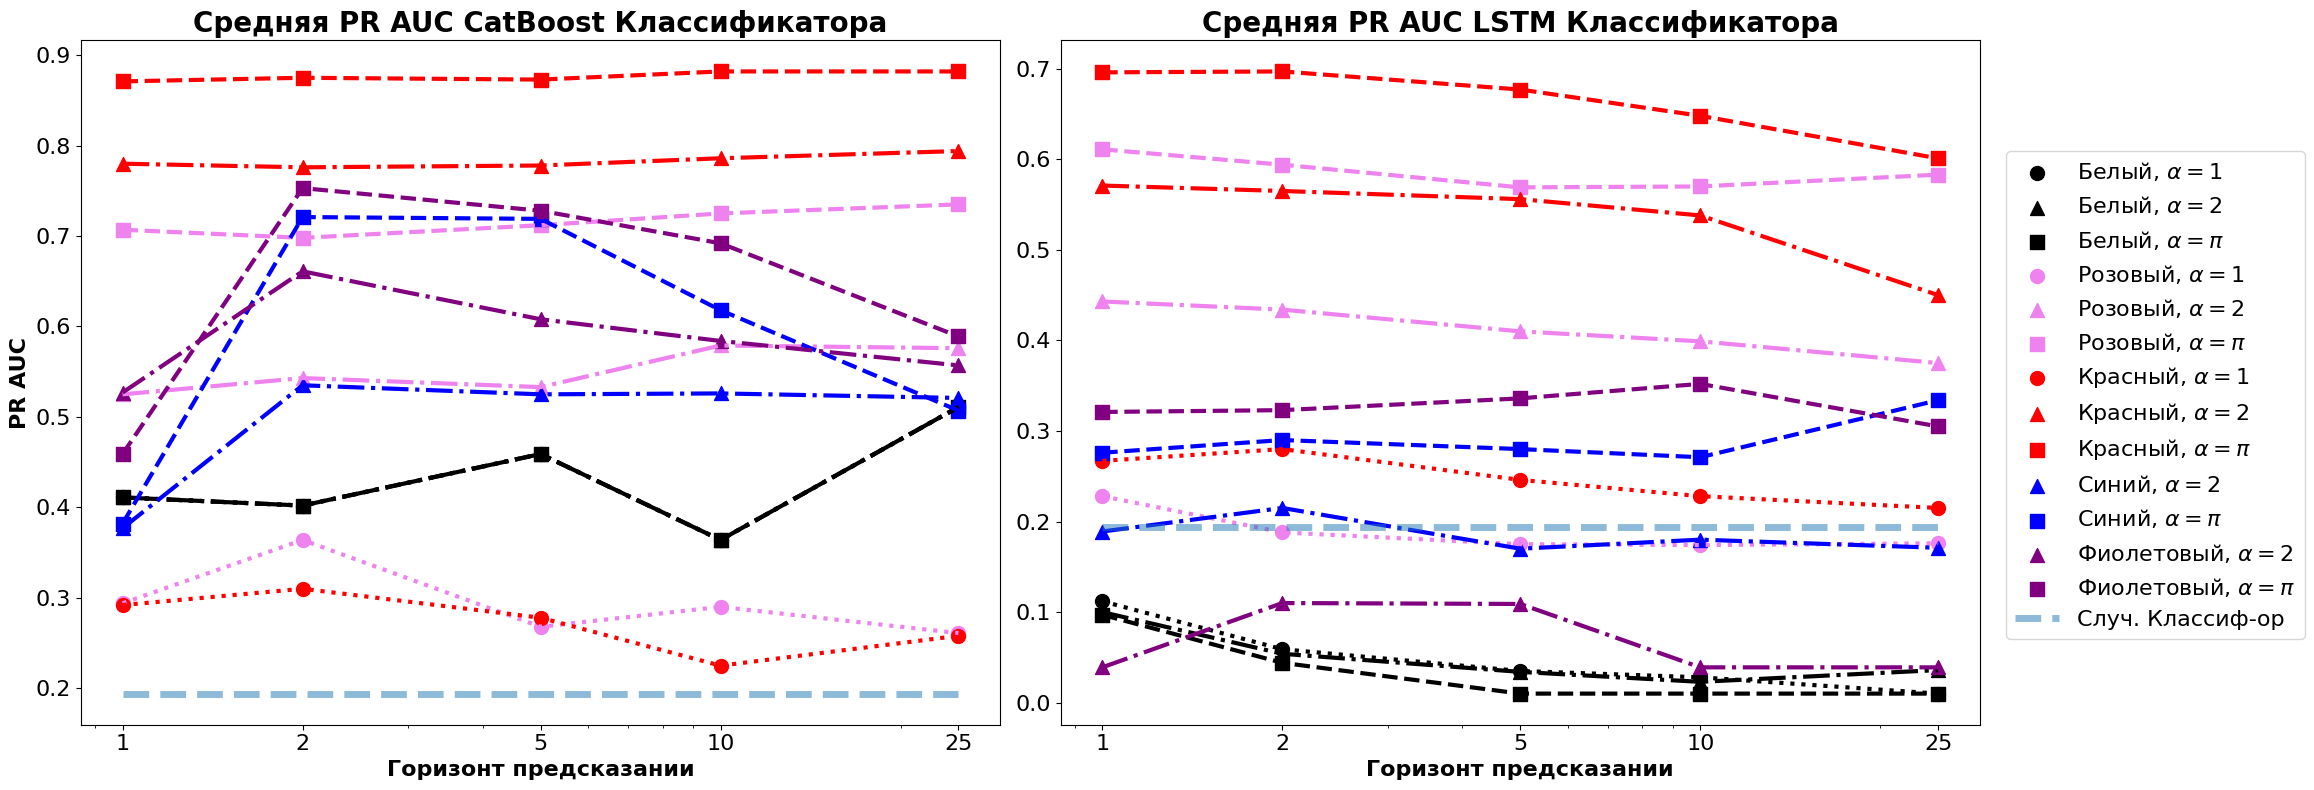

In [140]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

horizon = [1, 2, 5, 10, 25]

# # catboost

# ax[0, 0].scatter(horizon, ba_n1, 100, color='black', marker='o', label='N(0, 1)')
# ax[0, 0].scatter(horizon, ba_n2, 100, color='black', marker='^', label='N(0, 2)')
# ax[0, 0].scatter(horizon, ba_np, 100, color='black', marker='s', label=r'N(0, $\pi$)')

# ax[0, 0].scatter(horizon, ba_p1, 100, color='violet', marker='o', label=r'Pink, $\alpha = 1$')
# ax[0, 0].scatter(horizon, ba_p2, 100, color='violet', marker='^', label=r'Pink, $\alpha = 2$')
# ax[0, 0].scatter(horizon, ba_pp, 100, color='violet', marker='s', label=r'Pink, $\alpha = \pi$')

# ax[0, 0].scatter(horizon, ba_r1, 100, color='red', marker='o', label=r'Red, $\alpha = 1$')
# ax[0, 0].scatter(horizon, ba_r2, 100, color='red', marker='^', label=r'Red, $\alpha = 2$')
# ax[0, 0].scatter(horizon, ba_rp, 100, color='red', marker='s', label=r'Red, $\alpha = \pi$')

# # ax[0, 0].scatter(horizon, b1, 100, color='blue', marker='o', label=r'Blue, $\alpha = 1$')
# ax[0, 0].scatter(horizon, ba_b2, 100, color='blue', marker='^', label=r'Blue, $\alpha = 2$')
# ax[0, 0].scatter(horizon, ba_bp, 100, color='blue', marker='s', label=r'Blue, $\alpha = \pi$')

# # ax[0, 0].scatter(horizon, v1, color='violet', marker='0', label=r'Violet, $\alpha = 1$')
# ax[0, 0].scatter(horizon, ba_v2, 100, color='purple', marker='^', label=r'Violet, $\alpha = 2$')
# ax[0, 0].scatter(horizon, ba_vp, 100, color='purple', marker='s', label=r'Violet, $\alpha = \pi$')
 

# ax[0, 0].plot(horizon, ba_n1, color='black', linestyle=':', linewidth=3)
# ax[0, 0].plot(horizon, ba_n2, color='black', linestyle='-.', linewidth=3)
# ax[0, 0].plot(horizon, ba_np, color='black', linestyle='--', linewidth=3)

# ax[0, 0].plot(horizon, ba_p1, color='violet', linestyle=':', linewidth=3)
# ax[0, 0].plot(horizon, ba_p2, color='violet', linestyle='-.', linewidth=3)
# ax[0, 0].plot(horizon, ba_pp, color='violet', linestyle='--', linewidth=3)

# ax[0, 0].plot(horizon, ba_r1, color='red', linestyle=':', linewidth=3)
# ax[0, 0].plot(horizon, ba_r2, color='red', linestyle='-.', linewidth=3)
# ax[0, 0].plot(horizon, ba_rp, color='red', linestyle='--', linewidth=3)

# # ax[0, 0].scatter(horizon, b1, , color='blue', linestyle=':', linewidth=3)
# ax[0, 0].plot(horizon, ba_b2, color='blue', linestyle='-.', linewidth=3)
# ax[0, 0].plot(horizon, ba_bp, color='blue', linestyle='--', linewidth=3)

# # ax[0, 0].scatter(horizon, v1, , color='violet', linestyle=':', linewidth=3)
# ax[0, 0].plot(horizon, ba_v2, color='purple', linestyle='-.', linewidth=3)
# ax[0, 0].plot(horizon, ba_vp, color='purple', linestyle='--', linewidth=3)

# ax[0, 0].hlines(0.5, 1, 25, alpha=0.5, linewidth=5, linestyle='--')

# ax[0, 0].set_xscale('log')
# ax[0, 0].set_xticks(horizon)
# ax[0, 0].tick_params(labelsize=16)
# ax[0, 0].get_xaxis().set_major_formatter(tck.ScalarFormatter())
# ax[0, 0].set_xlabel('Prediction horizon', fontsize=16, weight='bold')
# ax[0, 0].set_ylabel('Balanced Accuracy', fontsize=16, weight='bold')
# ax[0, 0].set_title('Average Balanced Accuracy of Catboost Classifier', fontsize=20, weight='bold')

# ------------------------------------------------------------------------


ax[0].scatter(horizon, bp_n1, 100, color='black', marker='o', label=r'Белый, $\alpha = 1$')
ax[0].scatter(horizon, bp_n2, 100, color='black', marker='^', label=r'Белый, $\alpha = 2$')
ax[0].scatter(horizon, bp_np, 100, color='black', marker='s', label=r'Белый, $\alpha = \pi$')

ax[0].scatter(horizon, bp_p1, 100, color='violet', marker='o', label=r'Розовый, $\alpha = 1$')
ax[0].scatter(horizon, bp_p2, 100, color='violet', marker='^', label=r'Розовый, $\alpha = 2$')
ax[0].scatter(horizon, bp_pp, 100, color='violet', marker='s', label=r'Розовый, $\alpha = \pi$')

ax[0].scatter(horizon, bp_r1, 100, color='red', marker='o', label=r'Красный, $\alpha = 1$')
ax[0].scatter(horizon, bp_r2, 100, color='red', marker='^', label=r'Красный, $\alpha = 2$')
ax[0].scatter(horizon, bp_rp, 100, color='red', marker='s', label=r'Красный, $\alpha = \pi$')

# ax[1, 0].scatter(horizon, b1, 100, color='blue', marker='o', label=r'Blue, $\alpha = 1$')
ax[0].scatter(horizon, bp_b2, 100, color='blue', marker='^', label=r'Синий, $\alpha = 2$')
ax[0].scatter(horizon, bp_bp, 100, color='blue', marker='s', label=r'Синий, $\alpha = \pi$')

# ax[1, 0].scatter(horizon, v1, color='violet', marker='0', label=r'Violet, $\alpha = 1$')
ax[0].scatter(horizon, bp_v2, 100, color='purple', marker='^', label=r'Фиолетовый, $\alpha = 2$')
ax[0].scatter(horizon, bp_vp, 100, color='purple', marker='s', label=r'Фиолетовый, $\alpha = \pi$')
 

ax[0].plot(horizon, bp_n1, color='black', linestyle=':', linewidth=3)
ax[0].plot(horizon, bp_n2, color='black', linestyle='-.', linewidth=3)
ax[0].plot(horizon, bp_np, color='black', linestyle='--', linewidth=3)

ax[0].plot(horizon, bp_p1, color='violet', linestyle=':', linewidth=3)
ax[0].plot(horizon, bp_p2, color='violet', linestyle='-.', linewidth=3)
ax[0].plot(horizon, bp_pp, color='violet', linestyle='--', linewidth=3)

ax[0].plot(horizon, bp_r1, color='red', linestyle=':', linewidth=3)
ax[0].plot(horizon, bp_r2, color='red', linestyle='-.', linewidth=3)
ax[0].plot(horizon, bp_rp, color='red', linestyle='--', linewidth=3)

# ax[1, 0].scatter(horizon, b1, , color='blue', linestyle=':', linewidth=3)
ax[0].plot(horizon, bp_b2, color='blue', linestyle='-.', linewidth=3)
ax[0].plot(horizon, bp_bp, color='blue', linestyle='--', linewidth=3)

# ax[1, 0].scatter(horizon, v1, , color='violet', linestyle=':', linewidth=3)
ax[0].plot(horizon, bp_v2, color='purple', linestyle='-.', linewidth=3)
ax[0].plot(horizon, bp_vp, color='purple', linestyle='--', linewidth=3)

ax[0].hlines(0.1941, 1, 25, alpha=0.5, linewidth=5, linestyle='--')

ax[0].set_xscale('log')
ax[0].set_xticks(horizon)
ax[0].tick_params(labelsize=16)
ax[0].get_xaxis().set_major_formatter(tck.ScalarFormatter())
ax[0].set_xlabel('Горизонт предсказании', fontsize=16, weight='bold')
ax[0].set_ylabel('PR AUC', fontsize=16, weight='bold')
ax[0].set_title('Средняя PR AUC CatBoost Классификатора', fontsize=20, weight='bold')

# LSTM


# ax[0, 1].scatter(horizon, la_n1, 100, color='black', marker='o')
# ax[0, 1].scatter(horizon, la_n2, 100, color='black', marker='^')
# ax[0, 1].scatter(horizon, la_np, 100, color='black', marker='s')

# ax[0, 1].scatter(horizon, la_p1, 100, color='violet', marker='o')
# ax[0, 1].scatter(horizon, la_p2, 100, color='violet', marker='^')
# ax[0, 1].scatter(horizon, la_pp, 100, color='violet', marker='s')

# ax[0, 1].scatter(horizon, la_r1, 100, color='red', marker='o')
# ax[0, 1].scatter(horizon, la_r2, 100, color='red', marker='^')
# ax[0, 1].scatter(horizon, la_rp, 100, color='red', marker='s')

# ax[0, 1].scatter(horizon, la_b2, 100, color='blue', marker='^')
# ax[0, 1].scatter(horizon, la_bp, 100, color='blue', marker='s')

# ax[0, 1].scatter(horizon, la_v2, 100, color='purple', marker='^')
# ax[0, 1].scatter(horizon, la_vp, 100, color='purple', marker='s')
 

# ax[0, 1].plot(horizon, la_n1, color='black', linestyle=':', linewidth=3)
# ax[0, 1].plot(horizon, la_n2, color='black', linestyle='-.', linewidth=3)
# ax[0, 1].plot(horizon, la_np, color='black', linestyle='--', linewidth=3)

# ax[0, 1].plot(horizon, la_p1, color='violet', linestyle=':', linewidth=3)
# ax[0, 1].plot(horizon, la_p2, color='violet', linestyle='-.', linewidth=3)
# ax[0, 1].plot(horizon, la_pp, color='violet', linestyle='--', linewidth=3)

# ax[0, 1].plot(horizon, la_r1, color='red', linestyle=':', linewidth=3)
# ax[0, 1].plot(horizon, la_r2, color='red', linestyle='-.', linewidth=3)
# ax[0, 1].plot(horizon, la_rp, color='red', linestyle='--', linewidth=3)

# ax[0, 1].plot(horizon, la_b2, color='blue', linestyle='-.', linewidth=3)
# ax[0, 1].plot(horizon, la_bp, color='blue', linestyle='--', linewidth=3)

# ax[0, 1].plot(horizon, la_v2, color='purple', linestyle='-.', linewidth=3)
# ax[0, 1].plot(horizon, la_vp, color='purple', linestyle='--', linewidth=3)

# ax[0, 1].hlines(0.5, 1, 25, alpha=0.5, linewidth=5, linestyle='--')

# ax[0, 1].set_xscale('log')
# ax[0, 1].set_xticks(horizon)
# ax[0, 1].tick_params(labelsize=16)
# ax[0, 1].get_xaxis().set_major_formatter(tck.ScalarFormatter())
# ax[0, 1].set_xlabel('Prediction horizon', fontsize=16, weight='bold')
# ax[0, 1].set_ylabel('Balanced Accuracy', fontsize=16, weight='bold')
# ax[0, 1].set_title('Average Balanced Accuracy of LSTM Classifier', fontsize=20, weight='bold')
# ax[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

# ------------------------------------------------------------------------


ax[1].scatter(horizon, lp_n1, 100, color='black', marker='o')
ax[1].scatter(horizon, lp_n2, 100, color='black', marker='^')
ax[1].scatter(horizon, lp_np, 100, color='black', marker='s')

ax[1].scatter(horizon, lp_p1, 100, color='violet', marker='o')
ax[1].scatter(horizon, lp_p2, 100, color='violet', marker='^')
ax[1].scatter(horizon, lp_pp, 100, color='violet', marker='s')

ax[1].scatter(horizon, lp_r1, 100, color='red', marker='o')
ax[1].scatter(horizon, lp_r2, 100, color='red', marker='^')
ax[1].scatter(horizon, lp_rp, 100, color='red', marker='s')

ax[1].scatter(horizon, lp_b2, 100, color='blue', marker='^')
ax[1].scatter(horizon, lp_bp, 100, color='blue', marker='s')

ax[1].scatter(horizon, lp_v2, 100, color='purple', marker='^')
ax[1].scatter(horizon, lp_vp, 100, color='purple', marker='s')

ax[1].plot(horizon, lp_n1, color='black', linestyle=':', linewidth=3)
ax[1].plot(horizon, lp_n2, color='black', linestyle='-.', linewidth=3)
ax[1].plot(horizon, lp_np, color='black', linestyle='--', linewidth=3)

ax[1].plot(horizon, lp_p1, color='violet', linestyle=':', linewidth=3)
ax[1].plot(horizon, lp_p2, color='violet', linestyle='-.', linewidth=3)
ax[1].plot(horizon, lp_pp, color='violet', linestyle='--', linewidth=3)

ax[1].plot(horizon, lp_r1, color='red', linestyle=':', linewidth=3)
ax[1].plot(horizon, lp_r2, color='red', linestyle='-.', linewidth=3)
ax[1].plot(horizon, lp_rp, color='red', linestyle='--', linewidth=3)

ax[1].plot(horizon, lp_b2, color='blue', linestyle='-.', linewidth=3)
ax[1].plot(horizon, lp_bp, color='blue', linestyle='--', linewidth=3)

ax[1].plot(horizon, lp_v2, color='purple', linestyle='-.', linewidth=3)
ax[1].plot(horizon, lp_vp, color='purple', linestyle='--', linewidth=3)

ax[1].hlines(0.1941, 1, 25, alpha=0.5, linewidth=5, linestyle='--', label='Случ. Классиф-ор')

ax[1].set_xscale('log')
ax[1].set_xticks(horizon)
ax[1].tick_params(labelsize=16)
ax[1].get_xaxis().set_major_formatter(tck.ScalarFormatter())
ax[1].set_xlabel('Горизонт предсказании', fontsize=16, weight='bold')
# ax[1].set_ylabel('PR AUC', fontsize=16, weight='bold')
ax[1].set_title('Средняя PR AUC LSTM Классификатора', fontsize=20, weight='bold')

lgd = fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

plt.tight_layout()
plt.show()
fig.savefig('quality_metrics.jpeg', format='jpeg', dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [141]:
import pandas as pd


class cpd_pipeline(object):
    def __init__(self, method='log-return', n_sigmas=2):
        
        self.data   = []
        self.labels = []
        self.lr     = []
        self.deltas = ['hour', 'min30', 'min15', 'min5', 'min', 'milsec']
        self.method = method
        self.n_sigmas = n_sigmas
        self.horizon = [1, 2, 5]#, 10, 100]
    
    
    def get_data(self):
    
        for ds in self.deltas:
            dir_path = 'hf_data/' + ds + ' Si-1222.csv'
            data = pd.read_csv(dir_path)
            data.dropna(subset=['PRICE'], inplace=True)
            X = data['PRICE'].values
            # X = np.nan_to_num(X, posinf=max(X), neginf=min(X))
            self.data.append(X)

    
    def autoregression_matrix(self, X, periods=1, fill_value=0):
        shifted_x = [pd.DataFrame(X).shift(periods=i, fill_value=fill_value).values for i in range(periods)]
        return np.hstack(tuple(shifted_x))
    
    
    def labelling(self, X, min_size=2, model='rbf', jump=1):
        algo = ruptures.Pelt(min_size=min_size, model=model, jump=jump)
        algo.fit(X)
        labels = algo.predict(1)
        return labels
    
    
    def single_cpd_predict(self, dataset_id, window_size=10, margin=20):
        
        labels = self.labelling(self.data[dataset_id])
        if self.data[dataset_id].shape[0] in labels: labels = labels[:-1]
        y = np.zeros(self.data[dataset_id].shape[0])
        y[labels] = 1

        f1, acc, pr = dict.fromkeys(self.horizon), dict.fromkeys(self.horizon), dict.fromkeys(self.horizon)

        if self.method == 'lstm':
            lstm = binary_model(self.data[dataset_id], 0.7, 10, model='lstm')
            lstm.model_fit(verbose=0)
        
        for h in self.horizon:

            if self.method == 'boost':

                X_auto = self.autoregression_matrix(self.data[dataset_id], periods=h)
                
                X_train, X_test, y_train, y_test = tts(X_auto, y, test_size=0.5, shuffle=True)
                clf = CatBoostClassifier(verbose=0)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                y_true = y_test

            elif self.method == 'lstm':

                y_pred = lstm.labels(lstm.model_predict(h))['MARKS'].tolist()
                y_true = y
            
            if len(y_true) > len(y_pred):
                y_true = y_true[abs(len(y_true)-len(y_pred)):]
            else:
                y_pred = y_pred[abs(len(y_true)-len(y_pred)):]
            # y_true = y_true[1:]
            # y_pred = y_pred[1:]
            # print(len(y_true), len(y_pred))
            # print('----')
            f1_ = f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
            acc_ = balanced_accuracy_score(y_true, y_pred)
            precision, recall, thr = precision_recall_curve(y_true, y_pred)
            pr_ = auc(recall, precision)
    
            f1[h], acc[h], pr[h] = f1_, acc_, pr_
            
        return f1, acc, pr
    
    
    def cpd_predict(self):
        f1, acc, pr = dict.fromkeys(self.deltas), dict.fromkeys(self.deltas), dict.fromkeys(self.deltas)

        if len(self.data) == 0:
            self.get_data()
        
        for i in tqdm(range(len(self.data)-1), leave=True, position=0):
            f1[self.deltas[i]], acc[self.deltas[i]], pr[self.deltas[i]] = self.single_cpd_predict(i)
        # f1[self.deltas[1]], ri[self.deltas[1]] = self.single_cpd_predict(1)
        # print(res)
        
        return pd.DataFrame(f1).T, pd.DataFrame(acc).T, pd.DataFrame(pr).T

In [142]:
cpd = cpd_pipeline(method='boost')
cpd.cpd_predict()

  0%|          | 0/5 [00:00<?, ?it/s]

(               1         2         5
 hour    0.965517  0.874965  0.972603
 min30   0.965517  0.976109  0.969072
 min15   0.989865  0.979522  0.979522
 min5    0.988399  0.975395  0.989571
 min     0.997229  0.996185  0.996881
 milsec      None      None      None,
            1         2     5
 hour     0.5  0.492754   0.5
 min30    0.5       0.5   0.5
 min15    0.5       0.5   0.5
 min5     0.5  0.497672   0.5
 min      0.5       0.5   0.5
 milsec  None      None  None,
                1         2         5
 hour    0.533333      0.04  0.526667
 min30   0.533333  0.523333      0.53
 min15   0.510033  0.520067  0.520067
 min5    0.511468  0.007454  0.510321
 min     0.502764    0.5038  0.503109
 milsec      None      None      None)

In [143]:
cpd = cpd_pipeline(method='lstm')
cpd.cpd_predict()

  0%|          | 0/5 [00:00<?, ?it/s]

(               1         2         5
 hour    0.953488  0.954545  0.953488
 min30   0.959538  0.959538  0.959538
 min15   0.954198  0.939268  0.939268
 min5    0.973005  0.971832  0.966774
 min     0.990604  0.990608  0.990604
 milsec      None      None      None,
                1         2         5
 hour         0.5       0.5       0.5
 min30        0.5       0.5       0.5
 min15   0.571429   0.49711   0.49711
 min5    0.545455   0.54448  0.498054
 min     0.499807  0.499807  0.499807
 milsec      None      None      None,
                1         2         5
 hour    0.544444  0.543478  0.544444
 min30   0.538889  0.538889  0.538889
 min15   0.588188  0.019444  0.019444
 min5    0.555015  0.304997  0.010476
 min     0.003071   0.00307  0.003071
 milsec      None      None      None)

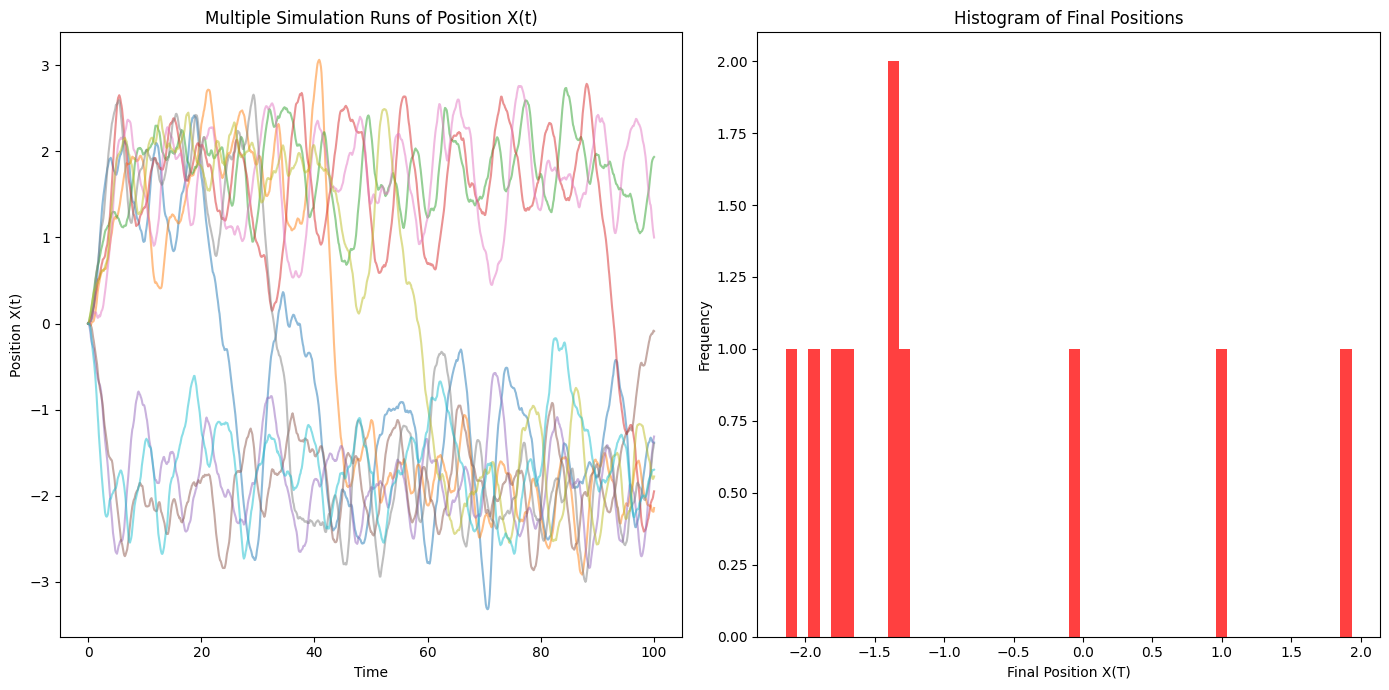

In [354]:
import numpy as np
import matplotlib.pyplot as plt
import colorednoise as cn

h = 0.1
T = 100
N = int(T / h)

num_runs = 10
X_final = np.zeros((num_runs, N))
V_final = np.zeros((num_runs, N))

for run in range(num_runs):
    X = np.zeros(N)
    V = np.zeros(N)
    X[0], V[0] = 0.0, 0.0
    
        # Simulate one run
    for i in range(N - 1):
        # Generating colored noise
        xi = cn.powerlaw_psd_gaussian(1, 2)[0]
        xi1 = cn.powerlaw_psd_gaussian(1, 2)[0]

        # Predictor step
        X1 = X[i] + h * Y[i]
        Y1 = Y[i] + h * (np.sin(X[i]) - X[i] + xi)

        # Corrector step
        X[i + 1] = X[i] + 0.5 * h * (Y[i] + Y1)
        Y[i + 1] = Y[i] + 0.5 * h * (np.sin(X[i]) + np.sin(X1) - X[i] - Y1 + xi + xi1)

    X_final[run, :] = X
    V_final[run, :] = V

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
for run in range(num_runs):
    plt.plot(np.linspace(0, T, N), X_final[run], alpha=0.5)
plt.title('Multiple Simulation Runs of Position X(t)')
plt.xlabel('Time')
plt.ylabel('Position X(t)')

plt.subplot(1, 2, 2)
plt.hist(X_final[:, -1], bins=50, alpha=0.75, color='r')
plt.title('Histogram of Final Positions')
plt.xlabel('Final Position X(T)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

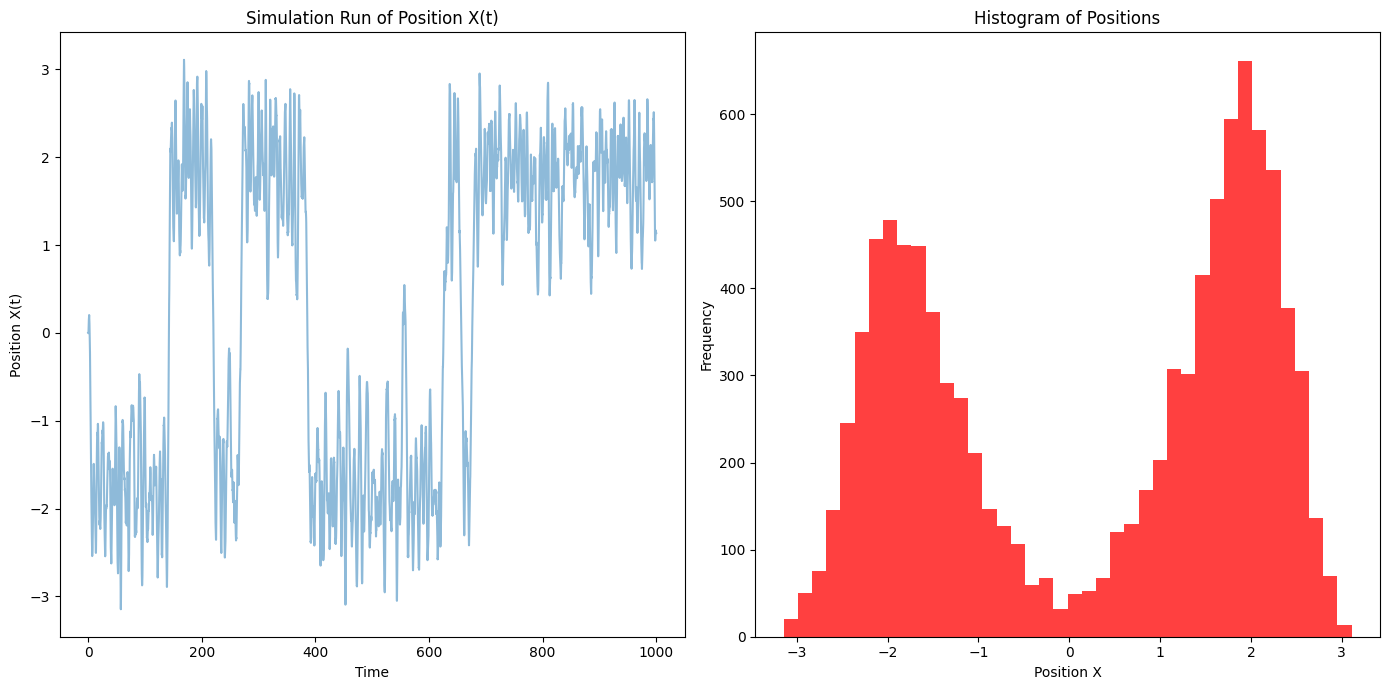

In [333]:
import numpy as np
import matplotlib.pyplot as plt
import colorednoise as cn

# Parameters
h = 0.1  # Time step
T = 1000  # Total time
N = int(T / h)  # Number of steps

# Initial conditions
X = np.zeros(N)
Y = np.zeros(N)
X[0], Y[0] = 0.0, 0.0

# Simulate one run
for i in range(N - 1):
    # Generating colored noise
    xi = cn.powerlaw_psd_gaussian(1, 2)[0]
    xi1 = cn.powerlaw_psd_gaussian(1, 2)[0]

    # Predictor step
    X1 = X[i] + h * Y[i]
    Y1 = Y[i] + h * (np.sin(X[i]) - X[i] + xi)

    # Corrector step
    X[i + 1] = X[i] + 0.5 * h * (Y[i] + Y1)
    Y[i + 1] = Y[i] + 0.5 * h * (np.sin(X[i]) + np.sin(X1) - X[i] - Y1 + xi + xi1)

# Plotting the solution
plt.figure(figsize=(14, 7))

# Time series plot of position X(t)
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, T, N), X, alpha=0.5)
plt.title('Simulation Run of Position X(t)')
plt.xlabel('Time')
plt.ylabel('Position X(t)')

# Histogram of the final position
plt.subplot(1, 2, 2)
plt.hist(X, bins=40, alpha=0.75, color='r')
plt.title('Histogram of Positions')
plt.xlabel('Position X')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


[0.         0.0066264  0.0231445  ... 2.82954329 2.89179536 2.97322589]


(array([340., 361., 367., 378., 363., 327., 321., 321., 288., 261., 269.,
        251., 209., 215., 221., 160., 168., 156., 119., 120.,  85., 102.,
        102., 101.,  77.,  82.,  66.,  47.,  61.,  69.,  63.,  49.,  66.,
         43.,  65.,  69.,  48.,  38.,  43.,  50.,  53.,  52.,  51.,  50.,
         47.,  42.,  43.,  55.,  64.,  58.,  90.,  86.,  89.,  95.,  88.,
         82., 103.,  86.,  84.,  81.,  86., 102., 122., 106.,  98.,  88.,
        109.,  87., 119., 128., 115.,  97.,  78.,  67.,  63.,  63.,  70.,
         75.,  61.,  58.,  28.,  15.,  21.,  19.,  18.,  25.,  20.,  20.,
          7.,  10.,   7.,  10.,  14.,   7.,   9.,  14.,   4.,  10.,   5.,
          5.]),
 array([0.        , 0.05568862, 0.11137725, 0.16706587, 0.22275449,
        0.27844312, 0.33413174, 0.38982037, 0.44550899, 0.50119761,
        0.55688624, 0.61257486, 0.66826348, 0.72395211, 0.77964073,
        0.83532935, 0.89101798, 0.9467066 , 1.00239523, 1.05808385,
        1.11377247, 1.1694611 , 1.22514972, 1.

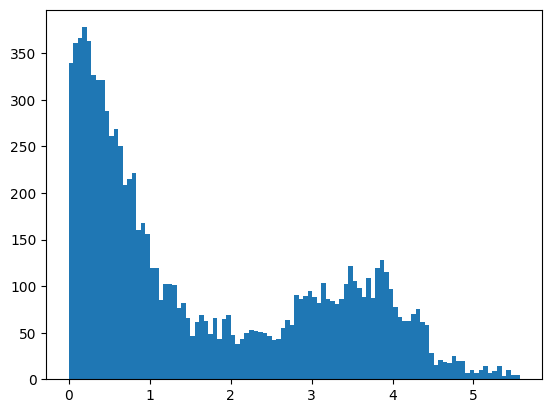

In [343]:
"""Ошибка апроксимации"""
import numpy as np
import matplotlib.pyplot as plt
import colorednoise as cn

# Функция для численного решения
def solve_numerical(h):
    # Parameters
    h = 0.1  # Time step
    T = 1000  # Total time
    N = int(T / h)  # Number of steps

    # Initial conditions
    X = np.zeros(N)
    Y = np.zeros(N)
    X[0], Y[0] = 00.0, 00.0
    
    for i in range(N - 1):
        # Generating colored noise
        xi = cn.powerlaw_psd_gaussian(1, 2)[0]
        xi1 = cn.powerlaw_psd_gaussian(1, 2)[0]

        # Predictor step
        X1 = X[i] + h * Y[i]
        Y1 = Y[i] + h * (np.sin(X[i]) - X[i] + xi)

        # Corrector step
        X[i + 1] = X[i] + 0.5 * h * (Y[i] + Y1)
        Y[i + 1] = Y[i] + 0.5 * h * (np.sin(X[i]) + np.sin(X1) - X[i] - Y1 + xi + xi1)
    return X

# Численное решение для двух разных значений шага по времени
xi_values_h1 = solve_numerical(0.01)
xi_values_h2 = solve_numerical(0.05)

# Вычисление ошибки аппроксимации
error = np.abs(xi_values_h1 - xi_values_h2)

# Вывод результатов
print(error)
plt.hist(error, bins=100)